In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os

In [3]:
working_dir = os.getcwd()

In [42]:
def get_one_contract_data_by_date(date_str, contract_pd):
    """Get the contract minute data by the date
    Trading hours:
        Sunday – Friday, 7:00 p.m. – 7:45 a.m. CT and 
        Monday – Friday, 8:30 a.m. – 1:20 p.m. CT
    Define the last day's night-time and today's day-time as today's trading hours
    
    Args:
        date_str: str, the date we want to extract the main contract data, e.g. "2016-01-04"
        contract_path: str, the main contract path, e.g. "../data/ZC/ZCH16.csv"
        
    Returns:
        pandas.DataFrame
    
    """
    year, month, day = map(int, date_str.split('-'))
    last_date_str = (datetime(year, month, day) - timedelta(days=1)).strftime("%Y-%m-%d")
    
    # all_data = pd.read_csv(contract_path, header=0, index_col=0, parse_dates=[0])
    all_data = contract_pd
    all_data['Volume'] = all_data.TotalVolume.diff()
    
    last_day_data = all_data.loc[last_date_str].between_time("19:01", "23:59")
    today_data_night = all_data.loc[date_str].between_time("0:00", "7:45")
    today_data_morning = all_data.loc[date_str].between_time("8:31", "13:20")
    
    data = last_day_data.append(today_data_night, ignore_index=False)
    data = data.append(today_data_morning, ignore_index=False)
    data.iloc[0, 5] = data.iloc[0, 4] #The first minute's trading volume 
    return data


In [39]:
def extract_data_from_unique_contract(contract_path, unique_dates):
    contract_pd = pd.read_csv(contract_path, header=0, index_col=0, parse_dates=[0])
    contract_pd = contract_pd.resample("1Min")
    contract_pd = contract_pd.fillna(method='ffill')
    data = pd.DataFrame(columns=["Open", "High", "Low", "Close", "TotalVolume", "Volume"])
    for single_date in unique_dates:
        dd = get_one_contract_data_by_date(single_date, contract_pd)
        data = data.append(dd, ignore_index=False)
    return data

In [22]:
def get_all_main_contract_data(main_contracts_path = working_dir+"/data/ZC/front.csv", contracts_root_path = working_dir+"/data/ZC/"):
    """Combine the daily main contract data 
    Args:
        main_contracts_path: str, the path that have the daily main contract code
        contracts_root_path: str, the root path that have all the contract data
        
    Returns:
        data, pd.DataFrame,columns=["Open", "High", "Low", "Close", "TotalVolume", "Volume", "Change"], 
                            where "Change" == 1 indicate that the main contract changed that day
    
    """
    func_contract_to_path = lambda x: contracts_root_path + "ZC" + x + ".csv"
    
    main_contracts = pd.read_csv(main_contracts_path, header=None, names=['date_str', 'main_contract'])
    unique_contracts = main_contracts.main_contract.unique()
    
    data = pd.DataFrame(columns=["Open", "High", "Low", "Close", "TotalVolume", "Volume"])
    for single_contract in unique_contracts:
        contract_path = func_contract_to_path(single_contract)
        unique_dates = main_contracts.loc[main_contracts["main_contract"] == single_contract].date_str.unique()
        today_data = extract_data_from_unique_contract(contract_path, unique_dates)
        data = data.append(today_data, ignore_index=False)
        
    return data

In [43]:
%time all_data = get_all_main_contract_data()

CPU times: user 14.2 s, sys: 2.31 s, total: 16.5 s
Wall time: 16.5 s


In [44]:
all_data.to_csv(working_dir+"/data/combined_data.csv")

In [24]:
len(all_data)

849200

In [10]:
# Get the main contracts changing date
main_contracts = pd.read_csv(working_dir+"/data/ZC/front.csv", header=None, names=['date_str', 'main_contract'])
main_contracts['Change'] = main_contracts.main_contract.apply(lambda x: hash(x)).rolling(2).apply(lambda x: 1 if x[1] != x[0] else 0).fillna(1)
change_dates = main_contracts[main_contracts['Change'] == 1][['date_str', 'main_contract']].reset_index(drop=True)
change_dates


C:\Users\renhao\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


,date_str,main_contract
0,2016-01-04,H16
1,2016-02-24,K16
2,2016-04-20,N16
3,2016-06-29,U16
4,2016-08-17,Z16
5,2016-11-29,H17
6,2017-02-27,K17
7,2017-04-20,N17
8,2017-06-28,U17
9,2017-08-17,Z17


In [12]:
change_dates.to_csv(working_dir+"/data/main_contract_change_dates.csv", index=False)

,Open,High,Low,Close,TotalVolume,Volume
2016-01-03 19:01:00,359.50,360.00,359.00,359.75,1215,1215.0
2016-01-03 19:02:00,359.75,359.75,359.25,359.50,1715,500.0
2016-01-03 19:03:00,359.50,359.50,359.00,359.00,2059,344.0
2016-01-03 19:04:00,359.00,359.25,359.00,359.00,2077,18.0
2016-01-03 19:05:00,359.00,359.00,359.00,359.00,2119,42.0


In [36]:
def get_sub_data_between_time_interval(all_data,
                                   start_date="2016-01-03", 
                                   start_time_in_day="19:00:00", 
                                   end_date="2019-03-01", 
                                   end_time_in_day="13:20:00",
                                   include = True):
    start_index = start_date + " " + start_time_in_day
    end_index = end_date + " " + end_time_in_day
    t_interval = (all_data.index >= start_index) & (all_data.index <= end_index) \
        if include else \
        (all_data.index > start_index) & (all_data.index < end_index)
    sub_data = all_data.loc[t_interval]
    return sub_data

def get_sub_data_in_no_of_transactions(all_data,
                                   start_date="2016-01-03", 
                                   start_time_in_day="19:00:00", 
                                   no_of_trans = 10000,
                                   include = True):
    start_index = start_date + " " + start_time_in_day
    t_interval = (all_data.index >= start_index) \
        if include else \
        (all_data.index > start_index)
    sub_data = all_data.loc[t_interval][:no_of_trans]
    return sub_data
    
def get_combined_sub_data_by_period(all_data,
                                    start_date="2016-01-03", 
                                    start_time_in_day="19:00:00",
                                    end_date="2019-03-01", 
                                    end_time_in_day="13:20:00",
                                    period = "D",
                                    include = True):
    # start_index = start_date + " " + start_time_in_day
    # end_index = end_date + " " + end_time_in_day
    # t_interval = (all_data.index >= start_index) & (all_data.index <= end_index) \
    #     if include else \
    #     (all_data.index > start_index) & (all_data.index < end_index)
    # sub_data = all_data.loc[t_interval]
    #sub_data = sub_data.resample("1Min").agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'TotalVolume': 'last'})
    sub_data = get_sub_data_between_time_interval(all_data, start_date, start_time_in_day, end_date, end_time_in_day, include=include)
    # sub_data = sub_data.between_time('19:00', '13:20', include_start=True, include_end=True)
    proxy = sub_data.index + pd.DateOffset(hours=5)
    combined_data = sub_data.groupby(proxy.date).agg(
        {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'TotalVolume': 'last'})
    combined_data = combined_data.reindex(columns=['Open', 'High', 'Low', 'Close', 'TotalVolume'])
    combined_data.index = pd.DatetimeIndex(combined_data.index)
    return combined_data.resample(period).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'TotalVolume': 'sum'})

In [9]:
def get_stat_val_between_time_interval(sub_data,
                                   attribute="Close", 
                                   stat_method="Mean"):
                                   # start_date="2016-01-03", 
                                   # start_time_in_day="19:00:00", 
                                   # end_date="2019-03-01", 
                                   # end_time_in_day="13:20:00",
                                   # no_of_trans = 10000,
                                   # include = True,
                                   # by_time = True):
    
    # sub_data = get_sub_data_between_time_interval(all_data, start_date, start_time_in_day, end_date, end_time_in_day, include) \
    #     if by_time else get_sub_data_in_no_of_transactions(all_data, start_date, start_time_in_day, no_of_trans, include)
    
    stat_dict = {
        "Mean": sub_data[attribute].mean(),
        "SD": sub_data[attribute].std(),
        "Diff": sub_data[attribute].diff(),
        "P_change": sub_data[attribute].pct_change(),
        "Log_return": np.log(sub_data[attribute]) - np.log(sub_data[attribute].shift(1)),
    }
    
    return stat_dict[stat_method]

In [53]:
# sd = get_sub_data_between_time_interval(all_data, end_date="2016-01-03", end_time_in_day="19:20:00")
# sd = get_combined_sub_data_by_period(all_data, end_date="2016-01-03", end_time_in_day="23:00:00",period="5Min")
# sd
sd_new = all_data.resample("5Min", label="right", closed="right").agg(
        {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
# print(sd_new)
print(len(sd_new))
sd_new = sd_new.dropna()
print(len(sd_new))
sd_new.to_csv(working_dir+"/data/combined_data_5mins.csv")
# sd_new = sd_new.fillna(method='ffill')
# sd_new
# all_data.tail(20)

321916
162892


,Open,High,Low,Close,TotalVolume
2016-01-04,359.50,360.0,350.5,352.00,170742
2016-01-05,352.75,354.5,352.5,354.25,8257


In [9]:
# Get all data from what we have, put your combined_data.csv under the folder named "data" in your working directory
all_data = pd.read_csv(working_dir+"/data/combined_data.csv", header=0, index_col=0, parse_dates=[0])

# Get tick data by time interval from 2016-01-03 19:00:00 to 2016-01-05 13:20:00
sample_data_1 = get_sub_data_between_time_interval(all_data, start_date="2016-01-03", start_time_in_day="19:00:00", end_date="2016-01-05", 
                              end_time_in_day="13:20:00")
print(sample_data_1.head())

# Get next 10000 transaction data start from 2016-01-03 19:00:00
sample_data_2 = get_sub_data_in_no_of_transactions(all_data, start_date="2016-01-03", start_time_in_day="19:00:00", no_of_trans=10000)
print(sample_data_2.head())

# Get daily data by time interval from 2016-01-03 19:00:00 to 2016-01-05 13:20:00
sample_data_3 = get_combined_sub_data_by_period(all_data, period="D", start_date="2016-01-03", start_time_in_day="19:00:00", end_date="2016-01-05", 
                               end_time_in_day="13:20:00")
print(sample_data_3.head())

# Get statistic values from sub data
# Mean close price for sample 1
mean_close_1 = get_stat_val_between_time_interval(sample_data_1, attribute="Close", stat_method="Mean")
print(mean_close_1)

# Mean volume for sample 1
mean_volume_1 = get_stat_val_between_time_interval(sample_data_1, attribute="Volume", stat_method="Mean")
print(mean_volume_1)

# Standard deviation of close price for sample 1
sd_close_1 = get_stat_val_between_time_interval(sample_data_1, attribute="Close", stat_method="SD")
print(sd_close_1)

# Change of close price for sample 1
diff_close_1 = get_stat_val_between_time_interval(sample_data_1, attribute="Close", stat_method="Diff")
print(diff_close_1)

# Percentage change of close price for sample 1
pchange_close_1 = get_stat_val_between_time_interval(sample_data_1, attribute="Close", stat_method="P_change")
print(pchange_close_1)

# Log return of close price for sample 1
lr_close_1 = get_stat_val_between_time_interval(sample_data_1, attribute="Close", stat_method="Log_return")
print(lr_close_1)

                       Open    High     Low   Close  TotalVolume  Volume
2016-01-03 19:01:00  359.50  360.00  359.00  359.75         1215  1215.0
2016-01-03 19:02:00  359.75  359.75  359.25  359.50         1715   500.0
2016-01-03 19:03:00  359.50  359.50  359.00  359.00         2059   344.0
2016-01-03 19:04:00  359.00  359.25  359.00  359.00         2077    18.0
2016-01-03 19:05:00  359.00  359.00  359.00  359.00         2119    42.0
                       Open    High     Low   Close  TotalVolume  Volume
2016-01-03 19:01:00  359.50  360.00  359.00  359.75         1215  1215.0
2016-01-03 19:02:00  359.75  359.75  359.25  359.50         1715   500.0
2016-01-03 19:03:00  359.50  359.50  359.00  359.00         2059   344.0
2016-01-03 19:04:00  359.00  359.25  359.00  359.00         2077    18.0
2016-01-03 19:05:00  359.00  359.00  359.00  359.00         2119    42.0
              Open   High     Low  Close  TotalVolume
2016-01-04  359.50  360.0  350.50  352.0       170742
2016-01-05  352.

In [11]:
sample_data_3 = get_combined_sub_data_by_period(all_data, period="D", start_date="2016-01-03", start_time_in_day="19:00:00", end_date="2017-01-03", 
                               end_time_in_day="13:20:00")
print(sample_data_3.head())

              Open    High     Low   Close  TotalVolume
2016-01-04  359.50  360.00  350.50  352.00       170742
2016-01-05  352.75  356.00  351.75  353.50       131944
2016-01-06  353.50  354.75  350.25  353.25       124626
2016-01-07  353.25  354.25  348.50  353.00       137217
2016-01-08  353.00  357.75  352.75  357.25       166509


In [12]:
print(sample_data_3.tail())

             Open   High     Low   Close  TotalVolume
2016-12-30  349.5  353.0  347.75  351.00        99748
2016-12-31    NaN    NaN     NaN     NaN            0
2017-01-01    NaN    NaN     NaN     NaN            0
2017-01-02    NaN    NaN     NaN     NaN            0
2017-01-03  352.0  358.5  351.50  355.75       158650


In [13]:
print(sample_data_3.loc[sample_data_3["TotalVolume"] == 0])

            Open  High  Low  Close  TotalVolume
2016-01-09   NaN   NaN  NaN    NaN            0
2016-01-10   NaN   NaN  NaN    NaN            0
2016-01-16   NaN   NaN  NaN    NaN            0
2016-01-17   NaN   NaN  NaN    NaN            0
2016-01-18   NaN   NaN  NaN    NaN            0
2016-01-23   NaN   NaN  NaN    NaN            0
2016-01-24   NaN   NaN  NaN    NaN            0
2016-01-30   NaN   NaN  NaN    NaN            0
2016-01-31   NaN   NaN  NaN    NaN            0
2016-02-06   NaN   NaN  NaN    NaN            0
2016-02-07   NaN   NaN  NaN    NaN            0
2016-02-13   NaN   NaN  NaN    NaN            0
2016-02-14   NaN   NaN  NaN    NaN            0
2016-02-15   NaN   NaN  NaN    NaN            0
2016-02-20   NaN   NaN  NaN    NaN            0
2016-02-21   NaN   NaN  NaN    NaN            0
2016-02-27   NaN   NaN  NaN    NaN            0
2016-02-28   NaN   NaN  NaN    NaN            0
2016-03-05   NaN   NaN  NaN    NaN            0
2016-03-06   NaN   NaN  NaN    NaN      

In [1]:
import src.CornCracker as CC

In [2]:
all_data = CC.read_data_from_path()

In [18]:
all_data.tail()

,Open,High,Low,Close,TotalVolume,Volume
2019-01-25 13:16:00,380.25,380.25,379.75,380.25,115213,1496.0
2019-01-25 13:17:00,380.00,380.25,380.00,380.00,115482,269.0
2019-01-25 13:18:00,380.00,380.25,380.00,380.25,115856,374.0
2019-01-25 13:19:00,380.25,380.25,380.00,380.25,117002,1146.0
2019-01-25 13:20:00,380.25,380.25,380.00,380.25,118004,1002.0


In [4]:
daily_data = CC.get_combined_sub_data_by_period(all_data)

In [6]:
len(daily_data.dropna())

772

In [8]:
CC.save_data_to_path(daily_data.dropna(), CC.working_dir + "/data/combined_daily_data.csv")

In [9]:
weekly_data = CC.get_combined_sub_data_by_period(all_data, period="W")

In [10]:
CC.save_data_to_path(weekly_data.dropna(), CC.working_dir + "/data/combined_weekly_data.csv")

In [11]:
daily_data = daily_data.dropna()

In [20]:
weekly_data.head()

,Open,High,Low,Close,TotalVolume
2016-01-10,359.5,360.00,348.5,357.25,731038
2016-01-17,357.0,363.75,349.5,363.25,962380
2016-01-24,364.0,372.00,364.0,370.00,771628
2016-01-31,370.0,372.50,365.0,371.50,830375
2016-02-07,371.0,373.75,365.5,365.50,844476


In [13]:
import seaborn as sns

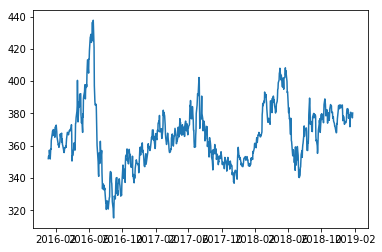

In [16]:
sns.lineplot(data = daily_data["Close"])

In [15]:
daily_data.index

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2019-01-11', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-22', '2019-01-23',
               '2019-01-24', '2019-01-25'],
              dtype='datetime64[ns]', length=772, freq=None)

In [25]:
daily_data.sort_values(by=['TotalVolume'], ascending=False)[:10]

,Open,High,Low,Close,TotalVolume
2016-03-31,366.75,367.25,347.50,350.50,501024
2017-06-07,378.25,387.00,378.25,385.00,482660
2018-02-07,363.75,365.75,362.50,365.00,457490
2017-11-09,347.50,349.75,340.75,342.00,445053
2017-06-08,385.00,391.75,384.25,384.25,369166
2016-04-13,363.00,374.75,363.00,373.75,368844
2018-03-29,373.75,389.25,373.75,387.75,354804
2017-02-28,368.75,386.25,368.50,373.00,354124
2018-04-04,388.00,389.00,372.00,380.50,346763
2016-04-21,399.00,407.25,388.50,388.75,339711


In [28]:
CC.get_stat_val_between_time_interval(daily_data, attribute='TotalVolume', stat_method='P_change').sort_values(ascending=False)[:10]

2017-03-31    2.185432
2018-09-28    1.632099
2018-09-12    1.630404
2016-03-31    1.581134
2018-11-26    1.499547
2018-11-01    1.472707
2018-03-29    1.450913
2018-10-05    1.363173
2017-11-09    1.353906
2016-09-30    1.295524
Name: TotalVolume, dtype: float64

In [29]:
CC.get_stat_val_between_time_interval(daily_data, attribute='Close', stat_method='P_change').sort_values(ascending=False)[:10]

2016-07-08    0.042522
2018-06-29    0.042059
2016-04-20    0.041612
2018-03-29    0.038848
2016-10-13    0.037064
2018-08-17    0.036936
2017-08-31    0.036232
2016-08-17    0.035034
2016-12-05    0.032421
2016-07-13    0.031272
Name: Close, dtype: float64

In [67]:
import pywt

def circular_convolve_d(h_t, v_j_1, j):
    '''
    jth level decomposition
    h_t: \tilde{h} = h / sqrt(2)
    v_j_1: v_{j-1}, the (j-1)th scale coefficients
    return: w_j (or v_j)
    '''
    N = len(v_j_1)
    L = len(h_t)
    w_j = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t - 2 ** (j - 1) * l, N)
        v_p = np.array([v_j_1[ind] for ind in index])
        w_j[t] = (np.array(h_t) * v_p).sum()
    return w_j

def circular_convolve_s(h_t, g_t, w_j, v_j, j):
    '''
    (j-1)th level synthesis from w_j, w_j
    see function circular_convolve_d
    '''
    N = len(v_j)
    L = len(h_t)
    v_j_1 = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t + 2 ** (j - 1) * l, N)
        w_p = np.array([w_j[ind] for ind in index])
        v_p = np.array([v_j[ind] for ind in index])
        v_j_1[t] = (np.array(h_t) * w_p).sum()
        v_j_1[t] = v_j_1[t] + (np.array(g_t) * v_p).sum()
    return v_j_1


def modwt(x, filters, level):
    '''
    filters: 'db1', 'db2', 'haar', ...
    return: see matlab
    '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    wavecoeff = []
    v_j_1 = x
    for j in range(level):
        print ("level", j)
        w = circular_convolve_d(h_t, v_j_1, j + 1)
        v_j_1 = circular_convolve_d(g_t, v_j_1, j + 1)
        wavecoeff.append(w)
    wavecoeff.append(v_j_1)
    return np.vstack(wavecoeff)

In [73]:
s1 = pd.Series(np.log(all_data['Close']))
s1 = s1.tolist()

In [74]:
ws = modwt(s1, 'sym8', 3)

level 0


level 1


level 2


In [75]:
ws

array([[ 9.54182535e-04, -1.12516328e-03,  8.97029557e-05, ...,
        -2.82263025e-05, -4.05320196e-04,  1.27245386e-04],
       [-3.23768129e-04,  4.41312906e-06,  2.30105333e-04, ...,
         4.09663388e-04,  1.42816262e-04, -2.66543545e-04],
       [ 2.36374089e-04,  2.71086334e-04,  2.30866245e-04, ...,
        -7.27640306e-05,  3.85940968e-05,  1.53412504e-04],
       [ 5.93758106e+00,  5.93765857e+00,  5.93773654e+00, ...,
         5.93743477e+00,  5.93746098e+00,  5.93751285e+00]])

In [76]:
len(ws[0])

814460

In [89]:
for i in range(0,len(all_data)):
    if all_data.iloc[i]['Volume'] == 0:
        all_data.loc[i, 'Open'] = all_data.iloc[i]['Close']
    if i == 25:
        break

TypeError: cannot insert DatetimeIndex with incompatible label

In [140]:
from numpy import linalg as LA
def nor(sub_data):
    ret = sub_data.apply(LA.norm, axis=0)
    return ret.to_frame().T

def don(nor1, nor2):
    if len(nor1) == 0:
        return None
    return nor2 - nor1

def rbind(nor, don):
    return nor.append(don, ignore_index=True)

def rbind_list(list):
    ret = list[0]
    for i in range(1,len(list)):
        ret = ret.append(list[i])
    return ret

def ts_mean(sub_data):
    ret = sub_data.apply(np.mean, axis = 0)
    return ret.to_frame().T
  
def ts_std(sub_data):
    ret = sub_data.apply(np.std, axis = 0)
    return ret.to_frame().T
  
def ts_max(sub_data):
    ret = sub_data.apply(np.max, axis = 0)
    return ret.to_frame().T

def ts_min(sub_data):
    ret = sub_data.apply(np.min, axis = 0)
    return ret.to_frame().T

def ts_ptp(sub_data):
    ret = sub_data.apply(np.ptp, axis = 0)
    return ret.to_frame().T

def ts_1Q(sub_data):
    ret = sub_data.apply(lambda x: np.percentile(x,25), axis = 0)
    return ret.to_frame().T
  
def ts_2Q(sub_data):
    ret = sub_data.apply(lambda x: np.percentile(x,50), axis = 0)
    return ret.to_frame().T
  
def ts_3Q(sub_data):
    ret = sub_data.apply(lambda x: np.percentile(x, 75), axis = 0)
    return ret.to_frame().T

def get_statistic_features_helper(sub_data):
    ret = rbind_list(
        [ts_mean(sub_data), ts_min(sub_data), ts_max(sub_data), ts_1Q(sub_data), 
         ts_2Q(sub_data), ts_3Q(sub_data), ts_std(sub_data), ts_ptp(sub_data)])
    return ret

def get_statistic_features(sub_G_list):
    combined_data = rbind_list(sub_G_list)
    combined_data_nor = combined_data[combined_data.index == 0]
    H_nor = get_statistic_features_helper(combined_data_nor)
    combined_data_don = combined_data[combined_data.index == 1]
    H_don = get_statistic_features_helper(combined_data_don)
    return rbind(H_nor, H_don)

def generate_G_list(all_data, start_index=0, b=4, step=2):
    G_list = []
    nor1 = nor(all_data[start_index:start_index+b])
    for i in range(start_index+step, len(all_data), step):
        nor2 = nor(all_data[i:i+b])
        don_temp = don(nor1, nor2)
        g_temp = rbind(nor2, don_temp)
        G_list.append(g_temp)
    return G_list

def generate_H_list(G_list, f=2, step=2):
    H_list = []
    for i in range(0, len(G_list), step):
        sub_G_list = G_list[i:i+f]
        if len(sub_G_list) < f:
            break
        h_temp = get_statistic_features(sub_G_list)
        H_list.append(h_temp)
    return H_list

In [124]:
g_list = generate_G_list(all_data[:12])

In [141]:
h_list = generate_H_list(g_list)

In [142]:
for item in h_list:
    print(item)

          Open        High         Low       Close  TotalVolume       Volume
0   718.250076  718.375065  717.875022  718.062560  4296.691193   243.697026
1   718.125033  718.250044  717.750044  718.000087  4192.399313   140.228385
2   718.375120  718.500087  718.000000  718.125033  4400.983072   347.165667
3   718.187554  718.312554  717.812533  718.031323  4244.545253   191.962705
4   718.250076  718.375065  717.875022  718.062560  4296.691193   243.697026
5   718.312598  718.437576  717.937511  718.093796  4348.837132   295.431346
6     0.125043    0.125022    0.124978    0.062473   104.291879   103.468641
7     0.250087    0.250043    0.249956    0.124946   208.583759   206.937281
8    -0.625130   -0.875152   -0.250011   -0.562734   695.183175 -1114.568412
9    -0.750174   -1.000174   -0.374989   -0.625206   590.891296 -1218.037053
10   -0.500087   -0.750130   -0.125033   -0.500261   799.475055 -1011.099771
11   -0.687652   -0.937663   -0.312500   -0.593970   643.037235 -1166.302732